In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from math import cos, sin, pi, sqrt
%matplotlib inline

# Test with simple circles

In [2]:
with open("../data/sealion/TrainDots/873.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

In [3]:
with open("../data/sealion/TrainShape/873.pkl", "rb") as pfile:
    shape = pickle.load(pfile)

In [4]:
scale = 0.25

In [5]:
def scl(x, s):
    return int(np.round(x * s))

In [6]:
shape

(3328, 4992)

In [7]:
shape_scaled = (scl(shape[0], scale), scl(shape[1], scale))

In [8]:
shape_scaled

(832, 1248)

In [9]:
smap_all = np.zeros(shape_scaled, dtype=np.uint8)
for i, ds in enumerate(dots):
    for (x, y) in ds:
        xs, ys = scl(x, scale), scl(y, scale)
        smap = np.zeros(shape_scaled, dtype=np.uint8)
        cv2.circle(smap, (xs, ys), scl(expected_size_max[i], scale)//2, (1, 1, 1), -1)
        cv2.circle(smap, (xs, ys), scl(expected_size_min[i], scale)//2, (2, 2, 2), -1)
        smap_all = np.maximum(smap_all, smap)

NameError: name 'expected_size_max' is not defined

In [ ]:
cv2.imwrite("../data/f.png", smap_all)

In [ ]:
plt.imshow(smap_all)

# Apply double threshold on gaussian map

In [2]:
dmap = np.load("../data/sealion/TrainEllipseDensity/873_5.npz")["dmap"]

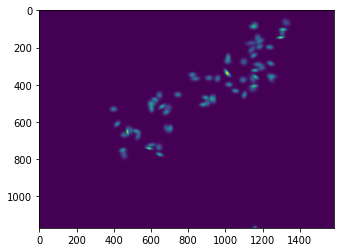

In [3]:
plt.imshow(np.sum(dmap, axis=-1))

In [4]:
expected_size = [78, 64, 60, 48, 28]

expected_size_min = [36, 32, 30, 24, 12]

expected_size_max = [120, 120, 100, 80, 40]

In [5]:
def gaussian2d_gen(x, y, theta, sx=1, sy=1, x0=0, y0=0, A=1):
    """ See https://fr.wikipedia.org/wiki/Fonction_gaussienne
    """    
    assert(sx != 0)
    assert(sy != 0)
    a = (cos(theta)**2) / (2 * sx**2) + (sin(theta)** 2)/ (2 * sy**2)
    b = -sin(2 * theta)/ (4 * sx**2) + sin(2 * theta) / (4 * sy**2)
    c = (sin(theta)**2) / (2 * sx**2) + (cos(theta)** 2)/ (2 * sy**2)
    dx = x - x0
    dy = y - y0
    
    return A * np.exp(-(a * dx**2 + 2 * b * dx * dy + c * dy**2))

In [6]:
def mask_gaussian(major, minor, theta):
    """ See http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ for the 5.991
    """
    df = 4.605 #5.991
    sigma_x = major/(2 * sqrt(df))
    sigma_y = minor/(2 * sqrt(df))
    half = int((max(sigma_x, sigma_y) * 3.5 ))  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d_gen(x, y, theta, sigma_x, sigma_y, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [7]:
def get_threshold_values(expected_size, real_size):
    thresholds = []
    for s, r in zip(expected_size, real_size):
        gaussian = mask_gaussian(s, s, pi/2)
        im = np.zeros(gaussian.shape, dtype=np.uint8)
        e = ((gaussian.shape[1]//2, gaussian.shape[0]//2), (r, r), 90)
        im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)
        threshold = np.max(gaussian[im == 0])
        thresholds.append(threshold)
    return thresholds

In [8]:
thresholds_max = get_threshold_values(expected_size, expected_size_max)

In [9]:
thresholds_min = get_threshold_values(expected_size, expected_size_min)

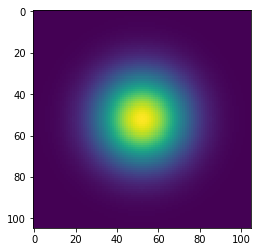

In [10]:
g = mask_gaussian(64, 64, pi/2)
plt.imshow(g)

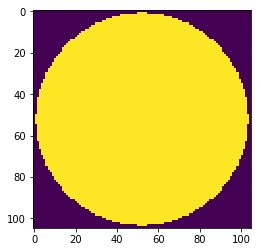

In [11]:
plt.imshow(g > thresholds_max[0])

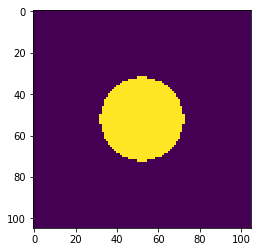

In [12]:
plt.imshow(g > thresholds_min[0])

In [18]:
def convert_dmap_to_smap(dmap, tmins, tmaxs):
    BACKGROUND = 0
    IGNORED = 1
    
    c = dmap.shape[-1]
    
    # Rescale between layer, due to different gaussians.
    # Rescale is done so that the threshold on each layer is 1.
    rescale = 1/np.asarray(tmins)
    dscaled = dmap * rescale
    
    # Keep only one non-zero value per pixel
    dmax = np.argmax(dscaled, axis=-1)
    
    # Final segmentation map
    smap_all = np.zeros(dmap.shape[:2])
    for i in range(c):
        fg = dmap[...,i] >= tmins[i]
        ig = np.logical_and(dmap[...,i] >= tmaxs[i], dmap[...,i] < tmins[i])
        smap = fg * (i+2) + ig
        # merge with full map
        # Replace background pixels by anything else
        mask_background = (smap_all == BACKGROUND)
        # Ignored pixels can be replace only by sealion
        mask_current_sealion_fg = smap > IGNORED
        mask_ignored = (smap_all == IGNORED) & (mask_current_sealion_fg)
        
        # Pixels where i has the priority, can be replaced only by sealion
        mask_priority = (dmax == i) & (mask_current_sealion_fg)
        mask = mask_background | mask_ignored | mask_priority
        smap_all[mask] = smap[mask]
        
    
    # Relabel, so that sealion types have values in [0, 4], background = 5 and ignored=6
    smap_all -= 2
    smap_all[smap_all==-2] = 5
    smap_all[smap_all==-1] = 6
    return smap_all.astype(np.uint8)

In [14]:
smap = convert_dmap_to_smap(dmap, thresholds_min, thresholds_max)

In [15]:
np.unique(smap, return_counts=True)

(array([0, 2, 3, 5, 6], dtype=uint8),
 array([   1237,   13982,   24348, 1674087,  139211]))

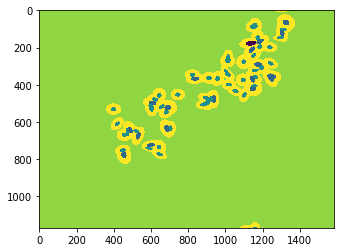

In [16]:
plt.imshow(smap)

In [137]:
def convert_dmap_to_smap_fgbg(dmap, tmins, tmaxs):
    c = dmap.shape[-1]
    smap_all = np.zeros(dmap.shape[:2])
    for i in range(c):
        fg = dmap[...,i] >= tmins[i]
        ig = np.logical_and(dmap[...,i] >= tmaxs[i], dmap[...,i] < tmins[i])
        smap = fg * 2 + ig
        smap_all = np.maximum(smap, smap_all)
    smap_all[smap_all==1]=3
    smap_all[smap_all==2]=1
    smap_all[smap_all==3]=2
    return smap_all.astype(np.uint8)

In [138]:
smap = convert_dmap_to_smap_fgbg(dmap, thresholds_min, thresholds_max)

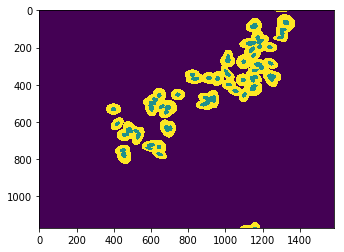

In [139]:
plt.imshow(smap)

In [140]:
np.unique(smap, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([1674087,   39567,  139211]))

In [55]:
def to_img(smap):
    colors_rgb = [(0, 0, 0), (255, 255, 0), (0, 255, 0)]
    im = np.zeros(smap.shape + (3, ), dtype=np.uint8)
    for i in range(len(colors_rgb)):
        im[smap==i, :] = colors_rgb[i]
    return im

In [56]:
cv2.imwrite("../data/test.png", to_img(smap))

True

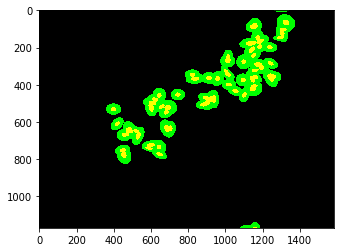

In [57]:
plt.imshow(to_img(smap))

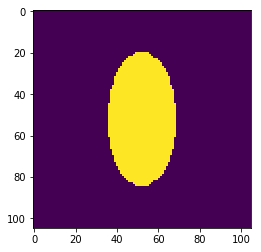

In [44]:
im = np.zeros(g.shape, dtype=np.uint8)
e = ((g.shape[0]//2, g.shape[0]//2), (64, 64/2), 90)
im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)
plt.imshow(im)

In [59]:
import progressbar

In [141]:
dst_dir = "../data/sealion/TrainEllipsesSegmentationIgnored"
src_dir = "../data/sealion/TrainEllipseDensity"
os.makedirs(dst_dir, exist_ok=True)
fns = os.listdir(src_dir)
with progressbar.ProgressBar(max_value=len(fns)) as bar:
    for i, fn in enumerate(fns):
        dmap = np.load(os.path.join(src_dir, fn))["dmap"]
        smap = convert_dmap_to_smap(dmap, thresholds_min, thresholds_max)
        np.savez_compressed(os.path.join(dst_dir, fn), smap=smap)
        bar.update(i)

100% (15168 of 15168) |###################| Elapsed Time: 1:43:56 Time: 1:43:56


# For circle guaussian density map

In [2]:
sealion_types = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]

In [3]:
sealion_sizes_px = {
    "adult_males": 72,
    "subadult_males": 64,
    "adult_females": 56,
    "juveniles": 32,
    "pups": 20
}

In [6]:
expected_size_min = [28, 24, 20, 16, 10]
expected_size_max = [120, 110, 90, 70, 36]

In [7]:
def gaussian2d(x, y, sx=1, sy=1, x0=0, y0=0, A=1):
    sxx = 2 * sx * sx
    syy = 2 * sy * sy
    xc = x - x0
    yc = y - y0
    xcc = xc * xc
    ycc = yc * yc
    return A * np.exp(-(xcc/sxx + ycc/syy))

In [8]:
def mask_gaussian(size):
    sigma = size / 3.0  # 97% of the gaussian in the size * size square
    half = int((sigma * 5 ) * 2)  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d(x, y, sigma, sigma, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [9]:
sealion_gaussian = {}
for sealion, size in sealion_sizes_px.items():
    sealion_gaussian[sealion] = mask_gaussian(size)

In [10]:
sealion_sizes = [sealion_sizes_px[t] for t in sealion_types]

In [11]:
sealion_masks = [sealion_gaussian[t] for t in sealion_types]

In [12]:
def get_threshold_values(expected_size, real_size):
    thresholds = []
    for s, r in zip(expected_size, real_size):
        gaussian = mask_gaussian(s)
        im = np.zeros(gaussian.shape, dtype=np.uint8)
        e = ((gaussian.shape[1]//2, gaussian.shape[0]//2), (r, r), 90)
        im = cv2.ellipse(im, e, color=(255, 255, 255), thickness=-1)
        threshold = np.max(gaussian[im == 0])
        thresholds.append(threshold)
    return thresholds

In [13]:
tmaxs = get_threshold_values(sealion_sizes, expected_size_max)
tmins = get_threshold_values(sealion_sizes, expected_size_min)

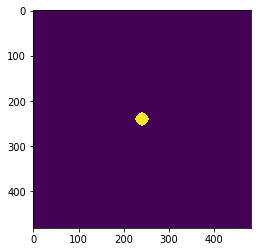

In [14]:
plt.imshow(sealion_masks[0] > tmins[0])

In [15]:
dmap = np.load("../data/sealion/TrainDensity/873_5.npz")["dmap"]

In [19]:
smap = convert_dmap_to_smap(dmap, tmins, tmaxs)

In [20]:
smap.dtype

dtype('uint8')

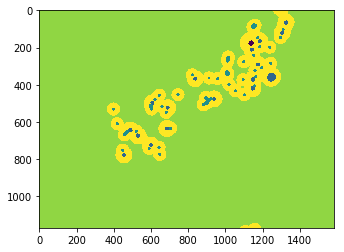

In [21]:
plt.imshow(smap)

## Convert all dmaps

In [23]:
import progressbar

In [24]:
dst_dir = "../data/sealion/TrainSegmentationIgnoredBlockB"
src_dir = "../data/sealion/TrainDensity/"
os.makedirs(dst_dir, exist_ok=True)
fns = os.listdir(src_dir)
with progressbar.ProgressBar(0, len(fns)) as pbar:
    for i, fn in enumerate(fns):
        dmap = np.load(os.path.join(src_dir, fn))["dmap"]
        smap = convert_dmap_to_smap(dmap, tmins, tmaxs)
        np.savez_compressed(os.path.join(dst_dir, fn), smap=smap)
        pbar.update(i)

100% (15168 of 15168) |###################| Elapsed Time: 1:55:07 Time: 1:55:07


In [64]:
smap = np.load("../data/sealion/TrainSegmentationIgnoredBlockB/873_5.npz")["smap"]

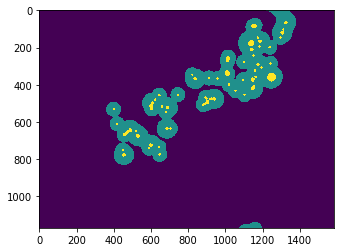

In [65]:
plt.imshow(smap)